# Imports

In [745]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas.api.types import CategoricalDtype

import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from matplotlib import style
style.use('seaborn')

import os
print(os.listdir("../input"))

%matplotlib inline

['train.csv', 'gender_submission.csv', 'test.csv']


In [746]:
pd.options.display.float_format = '{:,.2f}'.format

## Dataset Import

In [747]:
PATH = '../input/'

In [748]:
df = pd.read_csv(PATH + 'train.csv', low_memory=False, index_col=0)
test = pd.read_csv(PATH + 'test.csv', low_memory=False, index_col=0)
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.00,1,0,A/5 21171,7.25,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00,1,0,PC 17599,71.28,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.00,0,0,STON/O2. 3101282,7.92,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00,1,0,113803,53.10,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.00,0,0,373450,8.05,NaN,S


In [749]:
df.shape, test.shape

((891, 11), (418, 10))

In [750]:
df.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.00,891.00,891,891,714.00,891.00,891.00,891,891.00,204,889
unique,nan,nan,891,2,nan,nan,nan,681,nan,147,3
top,nan,nan,"Eitemiller, Mr. George Floyd",male,nan,nan,nan,CA. 2343,nan,G6,S
freq,nan,nan,1,577,nan,nan,nan,7,nan,4,644
mean,0.38,2.31,NaN,NaN,29.70,0.52,0.38,NaN,32.20,NaN,NaN
std,0.49,0.84,NaN,NaN,14.53,1.10,0.81,NaN,49.69,NaN,NaN
min,0.00,1.00,NaN,NaN,0.42,0.00,0.00,NaN,0.00,NaN,NaN
25%,0.00,2.00,NaN,NaN,20.12,0.00,0.00,NaN,7.91,NaN,NaN
50%,0.00,3.00,NaN,NaN,28.00,0.00,0.00,NaN,14.45,NaN,NaN
75%,1.00,3.00,NaN,NaN,38.00,1.00,0.00,NaN,31.00,NaN,NaN


In [751]:
test.describe(include='all')

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,418.00,418,418,332.00,418.00,418.00,418,417.00,91,418
unique,nan,418,2,nan,nan,nan,363,nan,76,3
top,nan,"Jonsson, Mr. Nils Hilding",male,nan,nan,nan,PC 17608,nan,B57 B59 B63 B66,S
freq,nan,1,266,nan,nan,nan,5,nan,3,270
mean,2.27,NaN,NaN,30.27,0.45,0.39,NaN,35.63,NaN,NaN
std,0.84,NaN,NaN,14.18,0.90,0.98,NaN,55.91,NaN,NaN
min,1.00,NaN,NaN,0.17,0.00,0.00,NaN,0.00,NaN,NaN
25%,1.00,NaN,NaN,21.00,0.00,0.00,NaN,7.90,NaN,NaN
50%,3.00,NaN,NaN,27.00,0.00,0.00,NaN,14.45,NaN,NaN
75%,3.00,NaN,NaN,39.00,1.00,0.00,NaN,31.50,NaN,NaN


Both the training set and the test set numerical features appear to have a similar distribution, which is promising for applying ML solutions.

## Dataset Initial Analysis

There were a total of 2224 passengers and crew on board the Titanic when the ship left for her maiden voyage. 1502 people died during the catastrophe that ensued after colliding with the iceberg, leaving the survival rate at roughly 32.5%.

If we only look at passengers though, there were approximately 1300 leaving with the ship and 812 that died, leaving the passenger survival rate at a higher level of 37%, which is close to the one in our training sample - 38%. Thus, we expect the test sample to display a similar survival rate.

Let's look closer at some of the features in our dataset:

**Pclass**

The ticket class, indicating wealth and cabin placement on the deck - the higher the class, the closer the assigned cabins were to the life boats.

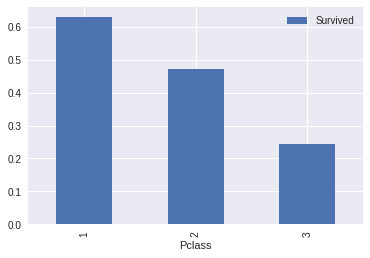

In [752]:
df[['Survived']].groupby(df['Pclass']).mean().plot.bar()
plt.show()

Not surprisingly, the survival rate appears to be decreasing sharply for higher class numbers

**Sex**

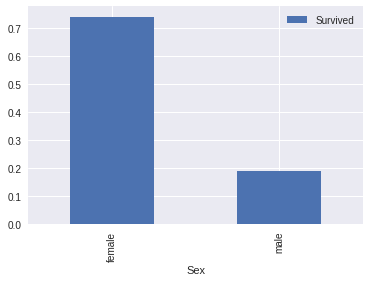

In [753]:
df[['Survived']].groupby(df['Sex']).mean().plot.bar()
plt.show()

Women had a much higher survival rate - not surprising as they most likely had priority over the male passengers into the lifeboats.

**Age**

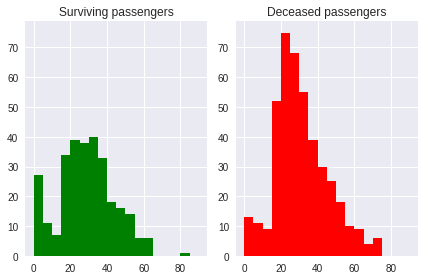

In [754]:
bins=[b for b in range(0, 91, 5)]
fig = plt.figure()
# ax0 = plt.subplot2grid((1, 2), (0, 0), colspan=2)
# plt.title("Age Histogram")

ax1 = plt.subplot2grid((1, 2), (0, 0))
df['Age'][df['Survived'] == 1].hist(bins=bins, color='g')
plt.title("Surviving passengers")
ax2 = plt.subplot2grid((1, 2), (0, 1), sharey=ax1)
df['Age'][df['Survived'] == 0].hist(bins=bins, color='r')
plt.title("Deceased passengers")
plt.tight_layout()
plt.show()

Notable difference between the surviving and deceased passenger age groups is that small children were more significantly more likely to survive.

In general, the conclusions we draw so far is that indeed, the principle of *"women and children first"* was followed.

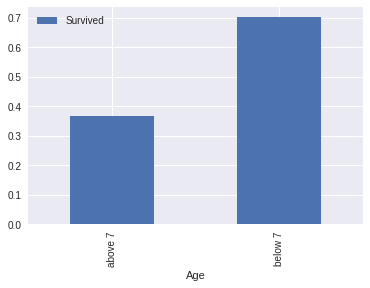

In [755]:
threshold = 7
df[['Survived']].groupby(df['Age'].apply(lambda x: f'below {threshold}' if x < threshold else f'above {threshold}')).mean().plot.bar()
plt.show()

**Name & title**

We extract the passenger title from the Name column:

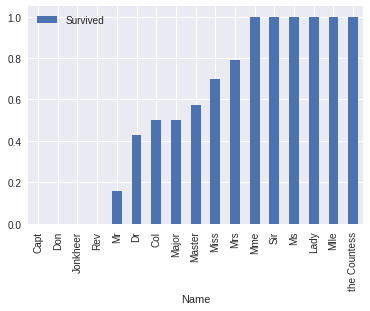

In [756]:
df[['Survived']].groupby(df['Name'].apply(lambda x: x.split(sep = ',')[1].split(sep = ".")[0].strip())).mean().sort_values(by="Survived").plot.bar()
plt.show()

Anyone with the title Mr. was very likely to die that day - this comes as no surprise after our analysis of passenger sex.

**SibSp and Parch**

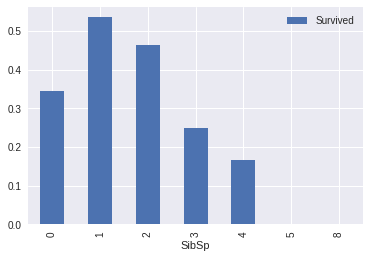

In [757]:
df[['Survived']].groupby([df['SibSp']]).mean().plot.bar()
plt.show()

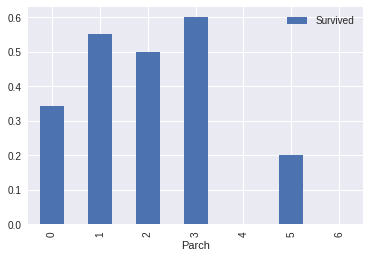

In [758]:
df[['Survived']].groupby([df['Parch']]).mean().plot.bar()
plt.show()

It's difficult to see any pattern in the above features. Given the fact they both relate to number of family members, perhaps we should look at them in combination:

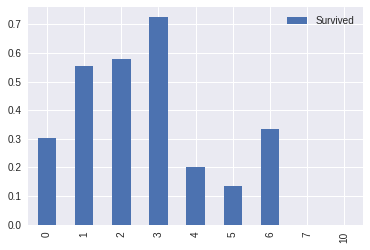

In [759]:
df[['Survived']].groupby([df['Parch'] + df['SibSp']]).mean().plot.bar()
plt.show()

In [760]:
df[['Survived']].groupby([df['Parch'] + df['SibSp']]).count()/df.shape[0]

,Survived
0,0.60
1,0.18
2,0.11
3,0.03
4,0.02
5,0.02
6,0.01
7,0.01
10,0.01


It looks like most passengers did not have family members onboard and those who did had a bigger chance of surviving - perhaps families 

**Embarked**

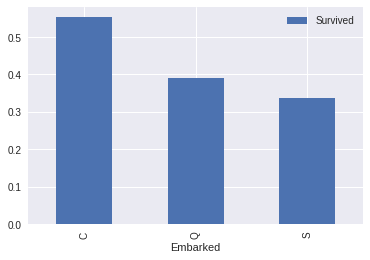

In [761]:
df[['Survived']].groupby([df['Embarked']]).mean().plot.bar()
plt.show()

In [762]:
df[['Survived']].groupby([df['Embarked']]).count()

,Survived
Embarked,
C,168
Q,77
S,644


Passengers from Cherbourg managed to survive more frequently for some reason.

## Data Pre-processing

**Missing Values**

We analyse the percentage of missing values in the dataset features:

In [763]:
df.isna().sum()[df.isna().sum() != 0]/df.shape[0] * 100

Age        19.87
Cabin      77.10
Embarked    0.22
dtype: float64

In [764]:
test.isna().sum()[test.isna().sum() != 0]/test.shape[0] * 100

Age     20.57
Fare     0.24
Cabin   78.23
dtype: float64

Let's look at cabin first, where over 77% observations are missing...

**Cabin**

In [765]:
df['Cabin'].value_counts()

G6             4
B96 B98        4
C23 C25 C27    4
F2             3
F33            3
D              3
C22 C26        3
E101           3
E121           2
C93            2
B58 B60        2
B35            2
B77            2
B28            2
D33            2
B49            2
E24            2
B20            2
E44            2
C125           2
C83            2
E33            2
D20            2
D35            2
C52            2
C92            2
C123           2
C68            2
D26            2
C65            2
              ..
A7             1
B38            1
A10            1
C7             1
E58            1
C62 C64        1
B30            1
C86            1
D11            1
E77            1
B86            1
B79            1
C148           1
A32            1
C103           1
C91            1
D49            1
B82 B84        1
F E69          1
T              1
C50            1
B41            1
D56            1
D30            1
D21            1
B71            1
C32            1
C85           

First, we make note the cabin numbers alone most likely introduce little new information to what we already know from analysing the Pclass and the cabin number is too passenger specific anyway. However, from looking at the picture below we see that interesting conclusions can be drawn from the letter idicating the deck as the upper decks are closer to the rescue boats as we hinted earlier:

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/84/Titanic_cutaway_diagram.png/687px-Titanic_cutaway_diagram.png" width="400">

That's why for the purpose of our analysis, we will create a new feature Deck - the extracted deck information from the Cabin feature.
In the process, we also replace the missing values with 'NA's.


In [766]:
df['Deck'] = df['Cabin'].fillna(value='NA').apply(lambda x: ''.join(filter(str.isalpha, x))[0] if x != 'NA' else x)
test['Deck'] = test['Cabin'].fillna(value='NA').apply(lambda x: ''.join(filter(str.isalpha, x))[0] if x != 'NA' else x)

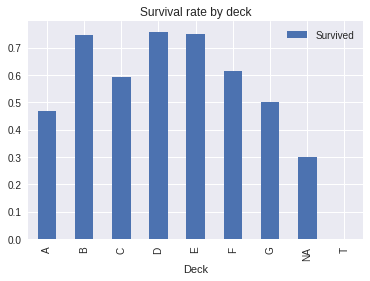

In [767]:
df[['Survived']].groupby(df['Deck']).mean().plot.bar()
plt.title("Survival rate by deck")
plt.show()

**Age**

Age is going to be a little more tricky. Our observation so far has been that children had a higher survival rate. Therefore it would be beneficial for the model accuracy to differentiate between children and adults in the missing age data group.

Let's have a look at the passenger names then:

In [768]:
df[['Name', 'Sex', 'Age']].sort_values('Age')

,Name,Sex,Age
PassengerId,,,
804,"Thomas, Master. Assad Alexander",male,0.42
756,"Hamalainen, Master. Viljo",male,0.67
645,"Baclini, Miss. Eugenie",female,0.75
470,"Baclini, Miss. Helene Barbara",female,0.75
79,"Caldwell, Master. Alden Gates",male,0.83
832,"Richards, Master. George Sibley",male,0.83
306,"Allison, Master. Hudson Trevor",male,0.92
828,"Mallet, Master. Andre",male,1.00
382,"Nakid, Miss. Maria (""Mary"")",female,1.00


It looks like young boys were addressed as *Master* in the register. In general, the median age differs depending on the title:

In [769]:
titles = ['Mr.', 'Master.', 'Rev.', 'Dr.', 'Sir.', 'Don.', 'Capt.', 'Lady.', 'Miss.', 'Ms.', 'Mrs.']

for title in titles:
    print(f"Title: {title}, Median of {df[['Name', 'Age']][df['Name'].str.contains(title)].median()}")

Title: Mr., Median of Age   31.00
dtype: float64
Title: Master., Median of Age   3.50
dtype: float64
Title: Rev., Median of Age   46.50
dtype: float64
Title: Dr., Median of Age   36.00
dtype: float64
Title: Sir., Median of Age   35.50
dtype: float64
Title: Don., Median of Age   45.00
dtype: float64
Title: Capt., Median of Age   70.00
dtype: float64
Title: Lady., Median of Age   48.00
dtype: float64
Title: Miss., Median of Age   21.00
dtype: float64
Title: Ms., Median of Age   28.00
dtype: float64
Title: Mrs., Median of Age   35.00
dtype: float64


In [770]:
df[['Name', 'Age']][~df['Name'].str.contains(', M')]

,Name,Age
PassengerId,,
31,"Uruchurtu, Don. Manuel E",40.00
150,"Byles, Rev. Thomas Roussel Davids",42.00
151,"Bateman, Rev. Robert James",51.00
246,"Minahan, Dr. William Edward",44.00
250,"Carter, Rev. Ernest Courtenay",54.00
318,"Moraweck, Dr. Ernest",54.00
399,"Pain, Dr. Alfred",23.00
557,"Duff Gordon, Lady. (Lucille Christiana Sutherl...",48.00
600,"Duff Gordon, Sir. Cosmo Edmund (""Mr Morgan"")",49.00


We'll therefore insert the missing age values using the median of the title:

In [771]:
def db_mod(db, title): db.loc[db[db['Name'].str.contains(title) & (db['Age'].isnull())].index, 'Age'] = df["Age"][df['Name'].str.contains(title)].median()

for title in titles: 
    db_mod(df, title=title)
    db_mod(test, title=title)

**Other missing values**

We are only missing a small number of values for Embarked in the training set, which we will fill with 'NA's

In [772]:
df['Embarked'].fillna(value='NA', inplace=True)

As for the missing fare information in the Test dataset, we will substitute it with the Pclass mean from the training set:

In [773]:
df[['Pclass', 'Fare']].groupby('Pclass').mean()

,Fare
Pclass,
1,84.15
2,20.66
3,13.68


In [774]:
test[test['Fare'].isnull()]

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Deck
PassengerId,,,,,,,,,,,
1044,3,"Storey, Mr. Thomas",male,60.50,0,0,3701,nan,NaN,S,NA


Turns out this is just a single observation. Let's fill it in:

In [775]:
test.loc[test[(test['Pclass'] == 3) & (test['Fare'].isnull())].index, 'Fare'] = df['Fare'][df['Pclass'] == 3].mean()

## Feature Selection

We start off by adding new features into our dataset:

In [776]:
df['FamSize'] = df['SibSp'] + df['Parch']
test['FamSize'] = test['SibSp'] + test['Parch']

In [777]:
df['Title'] = df['Name'].apply(lambda x: x.split(sep = ',')[1].split(sep = ".")[0].strip())
test['Title'] = test['Name'].apply(lambda x: x.split(sep = ',')[1].split(sep = ".")[0].strip())

In [778]:
df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked', 'Deck', 'FamSize', 'Title'],
      dtype='object')

We will now classify our features thet we'll be using for further analysis as categorical, dummy categorical, continuous and dependant variable:

In [779]:
cat_list = ['Sex', 'FamSize', 'Pclass']
dummy_list = ['Embarked', 'Deck', 'Title']
cont_list = ['Age', 'Fare']
dep = 'Survived'

In [780]:
train_set = df[cat_list + cont_list + dummy_list + [dep]].copy()
test_set = test[cat_list + cont_list + dummy_list].copy()

In order to transform features into numerical values, we transform the appropriate variables in the training set:

In [781]:
def process_df(df, is_train=True, train=train_set):
    for c in cat_list + cont_list + dummy_list:
        if is_train:
            if c in cat_list: df[c] = df[c].astype("category").cat.as_ordered()
        else:
            if c in cat_list: df[c] = df[c].astype(CategoricalDtype(train[c].cat.categories))
        if c in cont_list:
            df[c] = df[c].astype("float32")
        if c in dummy_list:
            cols = pd.get_dummies(df[c], prefix=c + "_")
            for col in cols.columns: df[col] = cols[col]
            df.drop(columns=c, inplace=True)

In [782]:
process_df(train_set)

We do a similar transformation on the test set, making sure the category mapping remains the same as in the training set:

In [783]:
process_df(test_set, is_train=False)

Then we transform the training set into a numerical representation:

In [784]:
train_num = train_set.copy()

for c in train_num.columns: train_num[c] = train_num[c].cat.codes if c in cat_list else train_num[c]

Now, let's look at the full correlation matrix for the selected features:

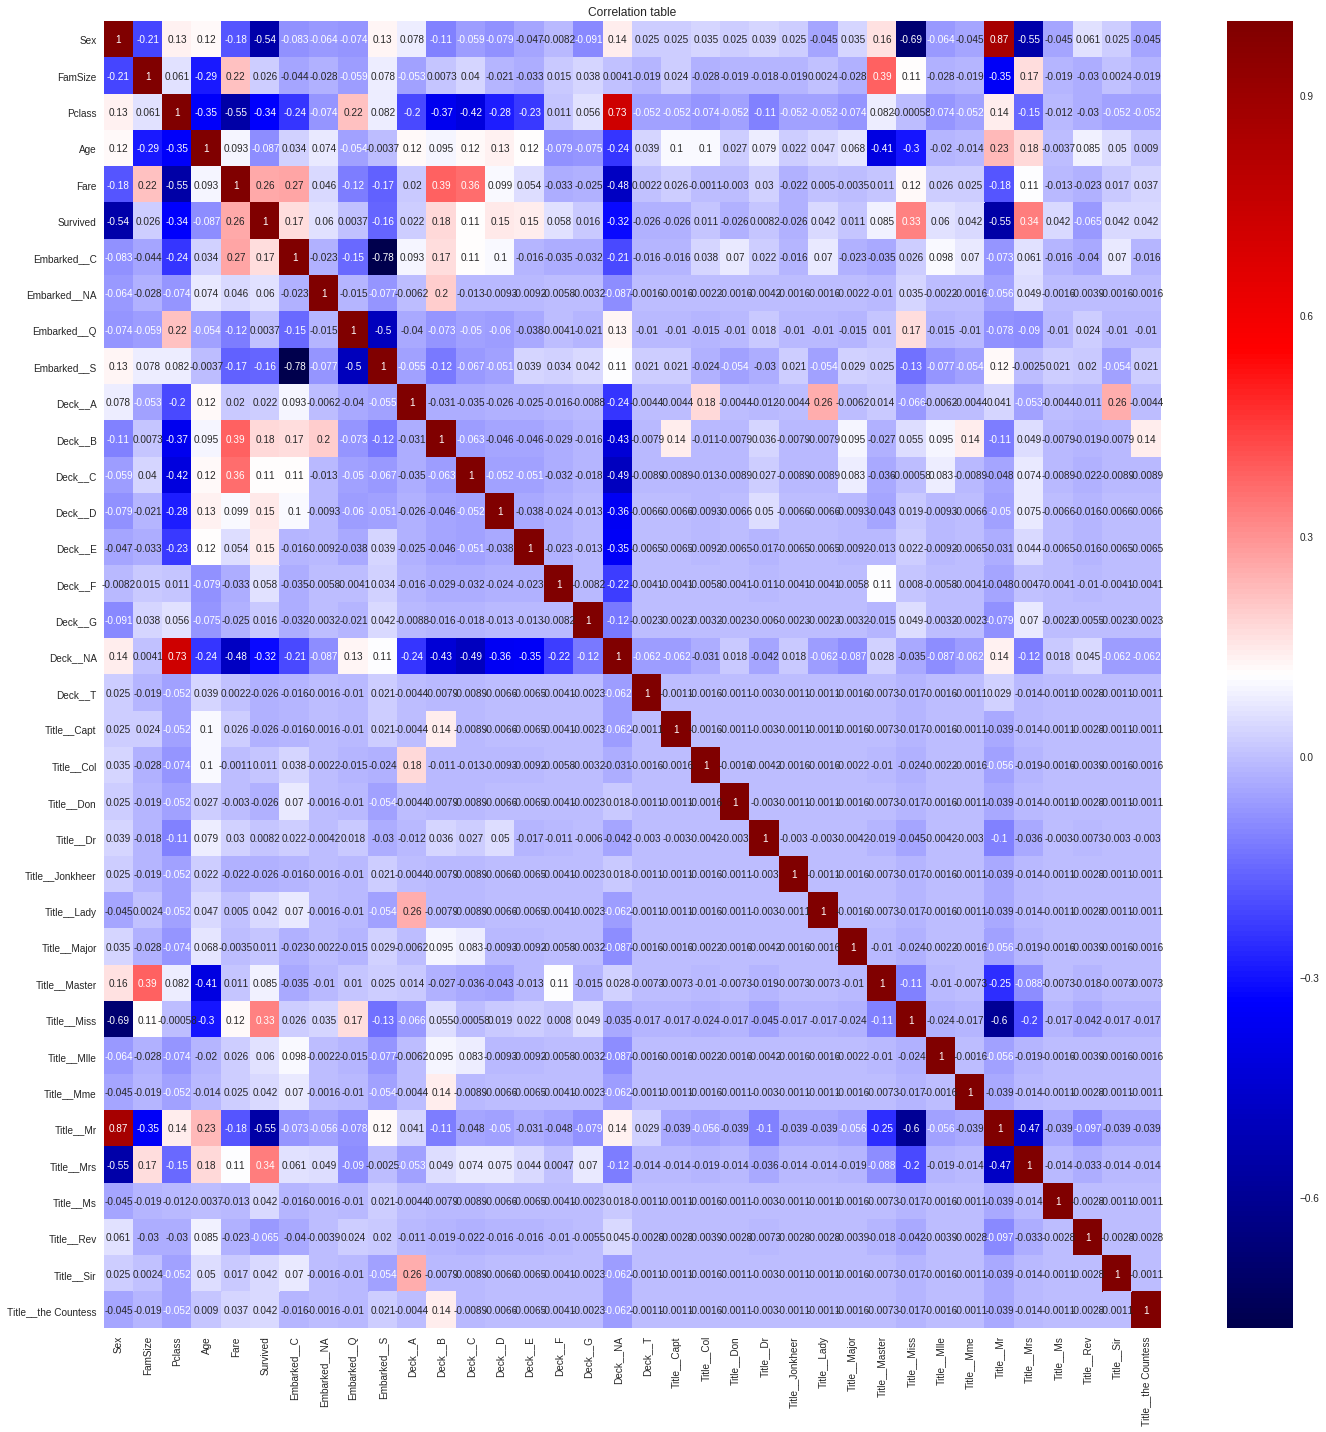

In [785]:
plt.figure(figsize=(20, 20))
plt.title("Correlation table")
# sns.heatmap(train_num[[dep] + cat_list + cont_list].corr(), annot=True, cmap="seismic")
sns.heatmap(train_num.corr(), annot=True, cmap="seismic")
plt.tight_layout()
plt.show()

In [786]:
test_num = test_set.copy()

for c in test_num.columns: test_num[c] = test_num[c].cat.codes if c in cat_list else test_num[c]

## Modelling

In [787]:
def acc(targ, pred): return (targ == pred).mean()

**Training / validation split**

Since the test set comprises ca. 30% of overall passangers, we will use a similar ratio to obtain a validation set:

In [788]:
r = 0.3
idxs = np.random.choice(np.arange(len(train_num)), size = int(len(train_num) * 0.3), replace=False)
idxs_mask = train_num.index.isin(idxs)

In [789]:
X_train = train_num.drop(columns='Survived')[~idxs_mask]
X_val = train_num.drop(columns='Survived')[idxs_mask]
y_train = train_num['Survived'][~idxs_mask]
y_val = train_num['Survived'][idxs_mask]

We compare the distributions in the validation and test sets:

In [790]:
X_val.describe(include='all')

,Sex,FamSize,Pclass,Age,Fare,Embarked__C,Embarked__NA,Embarked__Q,Embarked__S,Deck__A,Deck__B,Deck__C,Deck__D,Deck__E,Deck__F,Deck__G,Deck__NA,Deck__T,Title__Capt,Title__Col,Title__Don,Title__Dr,Title__Jonkheer,Title__Lady,Title__Major,Title__Master,Title__Miss,Title__Mlle,Title__Mme,Title__Mr,Title__Mrs,Title__Ms,Title__Rev,Title__Sir,Title__the Countess
count,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00,267.00
mean,0.69,0.91,1.34,29.15,32.12,0.19,0.00,0.09,0.72,0.03,0.06,0.04,0.04,0.03,0.01,0.00,0.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.04,0.19,0.00,0.00,0.63,0.12,0.00,0.00,0.00,0.00
std,0.46,1.59,0.84,12.44,50.60,0.39,0.00,0.29,0.45,0.17,0.23,0.20,0.20,0.18,0.11,0.00,0.41,0.00,0.00,0.06,0.00,0.00,0.06,0.00,0.06,0.20,0.39,0.06,0.00,0.48,0.32,0.00,0.06,0.00,0.00
min,0.00,0.00,0.00,0.83,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,1.00,21.00,7.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,0.00,2.00,30.00,13.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,2.00,35.50,31.27,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00
max,1.00,8.00,2.00,80.00,512.33,1.00,0.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,1.00,1.00,1.00,1.00,0.00,1.00,1.00,0.00,1.00,0.00,0.00


In [791]:
test_num.describe(include='all')

,Sex,FamSize,Pclass,Age,Fare,Embarked__C,Embarked__Q,Embarked__S,Deck__A,Deck__B,Deck__C,Deck__D,Deck__E,Deck__F,Deck__G,Deck__NA,Title__Col,Title__Dona,Title__Dr,Title__Master,Title__Miss,Title__Mr,Title__Mrs,Title__Ms,Title__Rev
count,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00,418.00
mean,0.64,0.82,1.27,29.86,35.57,0.24,0.11,0.65,0.02,0.04,0.08,0.03,0.02,0.02,0.00,0.78,0.00,0.00,0.00,0.05,0.19,0.57,0.17,0.00,0.00
std,0.48,1.41,0.84,13.03,55.85,0.43,0.31,0.48,0.13,0.20,0.28,0.17,0.15,0.14,0.05,0.41,0.07,0.05,0.05,0.22,0.39,0.50,0.38,0.05,0.07
min,0.00,0.00,0.00,0.17,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,0.00,0.00,22.00,7.90,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,0.00,2.00,30.00,14.45,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
75%,1.00,1.00,2.00,36.00,31.47,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00
max,1.00,8.00,2.00,76.00,512.33,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


The feature distributions appear to be reasonably similar.

**Random Forest classifier**

In [792]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

In [793]:
accurs = []
min = 1
max = 15
step = 1
for p in range(min, max, step):
    m = RandomForestClassifier(n_estimators=45, max_features=0.88, min_samples_leaf=p,
                              n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    preds = m.predict(X_val)
    print("-"*30, f'''
    n-estimators: {p}
    Training score: {m.score(X_train, y_train)*100:.2f}%
    Validation score: {m.score(X_val, y_val)*100:.2f}%
    Out-of-Bag score: {m.oob_score_*100:.2f}%
    Accuracy: {acc(y_val, preds)*100:.2f}%
    ''')
    accurs.append([p, acc(y_val, preds)])
accurs = np.array(accurs)
accurs[np.unravel_index(accurs[:, 1].argmax(), accurs[:, 1].shape)[0], :]

------------------------------ 
    n-estimators: 1
    Training score: 98.88%
    Validation score: 79.03%
    Out-of-Bag score: 82.05%
    Accuracy: 79.03%
    
------------------------------ 
    n-estimators: 2
    Training score: 94.39%
    Validation score: 81.65%
    Out-of-Bag score: 85.26%
    Accuracy: 81.27%
    
------------------------------ 
    n-estimators: 3
    Training score: 92.47%
    Validation score: 80.90%
    Out-of-Bag score: 83.65%
    Accuracy: 80.90%
    
------------------------------ 
    n-estimators: 4
    Training score: 90.71%
    Validation score: 80.52%
    Out-of-Bag score: 84.78%
    Accuracy: 80.52%
    
------------------------------ 
    n-estimators: 5
    Training score: 89.74%
    Validation score: 79.78%
    Out-of-Bag score: 83.65%
    Accuracy: 79.78%
    
------------------------------ 
    n-estimators: 6
    Training score: 89.74%
    Validation score: 80.15%
    Out-of-Bag score: 83.65%
    Accuracy: 80.15%
    
----------------------

array([12.        ,  0.82022472])

In [794]:
m = RandomForestClassifier(n_estimators=70, max_features=0.5, min_samples_leaf=1,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
preds = m.predict(X_val)
print("-"*30, f'''
Training score: {m.score(X_train, y_train)*100:.2f}%
Validation score: {m.score(X_val, y_val)*100:.2f}%
Out-of-Bag score: {m.oob_score_*100:.2f}%
Accuracy: {acc(y_val, preds)*100:.2f}%
''')

------------------------------ 
Training score: 99.04%
Validation score: 79.40%
Out-of-Bag score: 82.37%
Accuracy: 79.40%



In [795]:
def cross_val(X, y, cv=10):
    accuracies = cross_val_score(estimator = m,
                                 X = X,
                                 y = y,
                                 cv = cv) # k: number of folds - typically 10
    print("Average accuracy:", round(accuracies.mean()*100,1),"%")
    print("Standard deviation:", round(accuracies.std()*100,1),"%")

In [796]:
cross_val(X_train, y_train)

Average accuracy: 83.7 %
Standard deviation: 3.5 %


## Analysing the results

We'll look at the variable contribution to our overall accuracy:

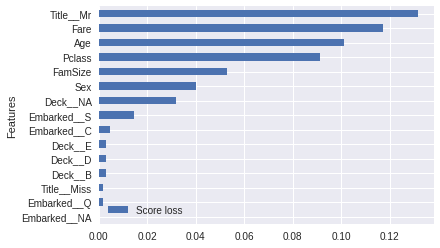

In [797]:
accs = []
targ = m.score(X_train, y_train)
num_features = 15

for c in X_train.columns:
    X = X_train.copy()
    X[c] = X[[c]].sample(frac=1).set_index(X.index)[c]  # random shuffle of one column
    accs.append(targ - m.score(X, y_train))
    

FI = sorted([[c, float(a)] for c, a in zip(X.columns, accs)], key=lambda x: x[1], reverse=True)[:num_features]
pd.DataFrame({'Score loss': [FI[i][1] for i in range(len(FI))], 'Features': [FI[i][0] for i in range(len(FI))]}).set_index('Features').sort_values(by='Score loss', ascending=True).plot.barh()
plt.show()

It looks like most variables do not add too much to the overall accuracy of the model. Let's reestimate based only on the top contributors:

In [798]:
top = 8
selected = [FI[i][0] for i in range(len(FI))][:top]
Xt = X_train[selected].copy()
Xv = X_val[selected].copy()
t = test_num[selected].copy()

In [799]:
m = RandomForestClassifier(n_estimators=70, max_features=0.5, min_samples_leaf=5,
                          n_jobs=-1, oob_score=True)
m.fit(Xt, y_train)
preds = m.predict(Xv)
print("-"*30, f'''
Training score: {m.score(Xt, y_train)*100:.2f}%
Validation score: {m.score(Xv, y_val)*100:.2f}%
Out-of-Bag score: {m.oob_score_*100:.2f}%
Accuracy: {acc(y_val, preds)*100:.2f}%
''')
cross_val(Xt, y_train)

------------------------------ 
Training score: 89.74%
Validation score: 80.15%
Out-of-Bag score: 85.10%
Accuracy: 80.15%

Average accuracy: 85.4 %
Standard deviation: 4.9 %


The accuracy is reasonably close to where it has been previously. Let's look at the variable contribution again:

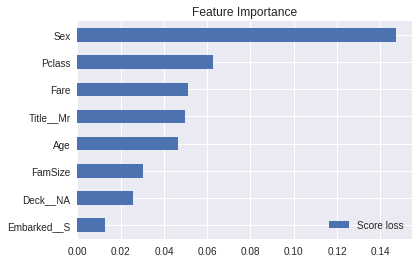

In [800]:
accs = []
targ = m.score(Xt, y_train)

for c in Xt.columns:
    X = Xt.copy()
    X[c] = X[[c]].sample(frac=1).set_index(X.index)[c]  # random shuffle of one column
    accs.append(targ - m.score(X, y_train))
    
pd.DataFrame({'Score loss': accs}, index=X.columns).sort_values(by='Score loss', ascending=True).plot.barh()
plt.title('Feature Importance')
plt.show() 

## Submission

In [801]:
m.predict(t).sum()/t.shape[0]

0.3684210526315789

The predicted survival rate is in the same order of magnitude as the one observed in our training data.

In [802]:
my_submission = pd.DataFrame({'Survived': m.predict(t)}, index=t.index)
my_submission.to_csv('submission.csv')